<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/21e_10kGNAD_huggingface_lr_find.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding a Good Learning Rate for pre-trained HuggingFace Transformer Models

References
* Leslie N. Smith: [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186)
* Sylvain Gugger: [The 1cycle policy](https://sgugger.github.io/the-1cycle-policy.html)
* FastAI `lr_find`
* ktrain `lr_find` ([1](https://nbviewer.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb#STEP-2-[Optional]:-Estimate-a-Good-Learning-Rate), [2](https://nbviewer.org/github/amaiya/ktrain/blob/master/tutorials/tutorial-02-tuning-learning-rates.ipynb#A-Learning-Rate-Finder), [3](https://github.com/amaiya/ktrain/blob/master/ktrain/lroptimize/lrfinder.py))
* PyTorch Lightning `lr_find` ([1](https://pytorch-lightning.readthedocs.io/en/stable/advanced/lr_finder.html), [2](https://pytorch-lightning.readthedocs.io/en/stable/_modules/pytorch_lightning/tuner/lr_finder.html#lr_find))
* [Automated Learning Rate Suggester](https://forums.fast.ai/t/automated-learning-rate-suggester/44199) (fastAI forum)

## Prerequisites

In [1]:
# checkpoint = "distilbert-base-german-cased"
checkpoint = "deepset/gbert-base"
# checkpoint = "deepset/gelectra-base"

## Check GPU

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jan  4 00:23:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    37W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install Packages

In [3]:
%%time
!pip install -q -U transformers datasets >/dev/null
# !pip install -q -U optuna >/dev/null

# check installed version
# !pip freeze | grep optuna        # optuna==2.10.0
!pip freeze | grep transformers  # transformers==4.15.0
!pip freeze | grep torch         # torch==1.10.0+cu111

transformers==4.15.0
torch @ https://download.pytorch.org/whl/cu111/torch-1.10.0%2Bcu111-cp37-cp37m-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu111/torchaudio-0.10.0%2Bcu111-cp37-cp37m-linux_x86_64.whl
torchsummary==1.5.1
torchtext==0.11.0
torchvision @ https://download.pytorch.org/whl/cu111/torchvision-0.11.1%2Bcu111-cp37-cp37m-linux_x86_64.whl
CPU times: user 46.9 ms, sys: 17.3 ms, total: 64.2 ms
Wall time: 4.67 s


In [4]:
from transformers import logging

# hide progress bar when downloading tokenizer and model (a workaround!)
logging.get_verbosity = lambda : logging.NOTSET

## Load Dataset

In [5]:
from datasets import load_dataset

gnad10k = load_dataset("gnad10")
label_names = gnad10k["train"].features["label"].names

Using custom data configuration default
Reusing dataset gnad10 (/root/.cache/huggingface/datasets/gnad10/default/1.1.0/3a8445be65795ad88270af4d797034c3d99f70f8352ca658c586faf1cf960881)


  0%|          | 0/2 [00:00<?, ?it/s]

## Data Preprocessing

* Loading the same Tokenizer that was used with the pretrained model.
* Define function to tokenize the text (with truncation to max input length of model.
* Run the tokenization

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_gnad10k = gnad10k.map(preprocess_function, batched=True).remove_columns("text")

Loading cached processed dataset at /root/.cache/huggingface/datasets/gnad10/default/1.1.0/3a8445be65795ad88270af4d797034c3d99f70f8352ca658c586faf1cf960881/cache-bc6a8b06dc72b2a1.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/gnad10/default/1.1.0/3a8445be65795ad88270af4d797034c3d99f70f8352ca658c586faf1cf960881/cache-2c4a7f3fbc1e560e.arrow


### Use Dynamic Padding

Apply panding only on longest text in batch - this is more efficient than applying padding on the whole dataset.

In [7]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Model Setup

We want to include the label names and save them together with the model.
The only way to do this is to create a Config and put them in. 

In [8]:
from transformers import AutoConfig, AutoModelForSequenceClassification

def model_init():
    """A function that instantiates the model to be used."""

    config = AutoConfig.from_pretrained(
        checkpoint,
        num_labels=len(label_names),
        id2label={i: label for i, label in enumerate(label_names)},
        label2id={label: i for i, label in enumerate(label_names)},
        )

    return AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)

In [9]:
epochs = 0.35
bs = 16

from transformers import Trainer, TrainerCallback, PrinterCallback, ProgressCallback, TrainingArguments, TrainerState, TrainerControl
from transformers.utils.notebook import NotebookProgressCallback, NotebookProgressBar

# https://github.com/huggingface/transformers/blob/05fa1a7ac17bb7aa07b9e0c1e138ecb31a28bbfe/src/transformers/trainer_callback.py#L160

class NoTableProgressCallback(NotebookProgressCallback):
    """Progress Callback that does not print log values in a table"""

    class NoTableProgressBar(NotebookProgressBar):
        def __init__(self, total: int):
            super().__init__(total)
        def write_line(self, values):
            pass  # don't add values to table

    def on_train_begin(self, args, state, control, **kwargs):
        super().on_train_begin(args, state, control, **kwargs)
        self.training_tracker = self.NoTableProgressBar(state.max_steps)


# https://github.com/huggingface/transformers/blob/v4.15.0/src/transformers/training_args.py#L73
training_args = TrainingArguments(
    output_dir="/tmp",
    report_to=[],
    log_level="error",
    disable_tqdm=False,

    logging_steps=1,

    # hyperparameters
    num_train_epochs=epochs,
    per_device_train_batch_size=bs,
    # per_device_eval_batch_size=bs,
    # learning_rate=lr,
    warmup_ratio=0.2,
    # weight_decay=weight_decay,
)

# https://github.com/huggingface/transformers/blob/master/src/transformers/trainer.py
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_gnad10k["train"],
    eval_dataset=tokenized_gnad10k["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# replace default notebook callback
trainer.remove_callback(NotebookProgressCallback)
trainer.add_callback(NoTableProgressCallback)

# result = trainer.train()

In [10]:
import pandas as pd

# log_df = pd.DataFrame(trainer.state.log_history[:-2]).set_index("step")
# log_df.plot(subplots=True, figsize=(6,8));

## Find best Learning Rate

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR

def get_lr_find_scheduler(optimizer, steps:int=100, min_lr:float=1e-7, max_lr:float=1e-2) -> LambdaLR:

    # take base lr from optimizer into account
    le = np.exp(np.linspace(np.log(min_lr), np.log(max_lr), num=steps))
    
    def lr_lambda(current_step: int):
        index = current_step if current_step < len(le) else len(le) - 1
        return le[index]

    return LambdaLR(optimizer, lr_lambda, last_epoch=-1)

In [12]:
from transformers.optimization import AdamW

steps=100

model = model_init()
optimizer = AdamW(model.parameters())
lr_scheduler = get_lr_find_scheduler(optimizer, steps=steps, min_lr=1e-4, max_lr=10)  # fix handling of base lr or 0.001

trainer_lr = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_gnad10k["train"],
    eval_dataset=tokenized_gnad10k["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    optimizers=(optimizer, lr_scheduler)
)

# replace default notebook callback
trainer_lr.remove_callback(NotebookProgressCallback)
trainer_lr.add_callback(NoTableProgressCallback)

trainer_lr.train();

In [15]:
log_df = pd.DataFrame(trainer_lr.state.log_history[:-2]).set_index("step")
# log_df.plot(subplots=True, figsize=(6,8));

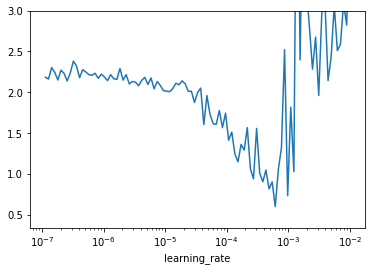

In [16]:
log_df[:steps-1].set_index("learning_rate").loss.plot()
plt.xscale("log")
plt.ylim([None,3]);

In [17]:
# from fastai - https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html#how-do-you-find-a-good-learning-rate

beta = 0.98
avg_loss = 0.0
smoothed = []

for i, loss in enumerate(log_df.loss):
    i+=1
    avg_loss = beta * avg_loss + (1-beta) * loss
    smoothed_loss = avg_loss / (1 - beta**i)
    smoothed.append(smoothed_loss)

log_df["loss_smooth"] = smoothed

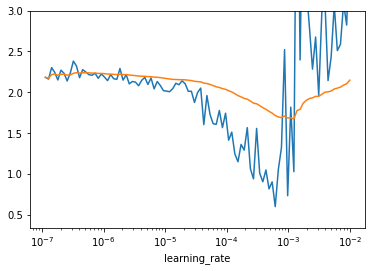

In [18]:
log_df[:steps-1].set_index("learning_rate").loss.plot()
log_df[:steps-1].set_index("learning_rate").loss_smooth.plot()
plt.xscale("log")
plt.ylim([None,3]);